In [ ]:
!pip install kats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 612 kB 4.4 MB/s 
     |████████████████████████████████| 353 kB 66.8 MB/s 
     |████████████████████████████████| 3.3 MB 47.6 MB/s 
     |████████████████████████████████| 950 kB 55.0 MB/s 
     |████████████████████████████████| 9.5 MB 41.5 MB/s 
     |████████████████████████████████| 347 kB 50.2 MB/s 
     |████████████████████████████████| 34.5 MB 15 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


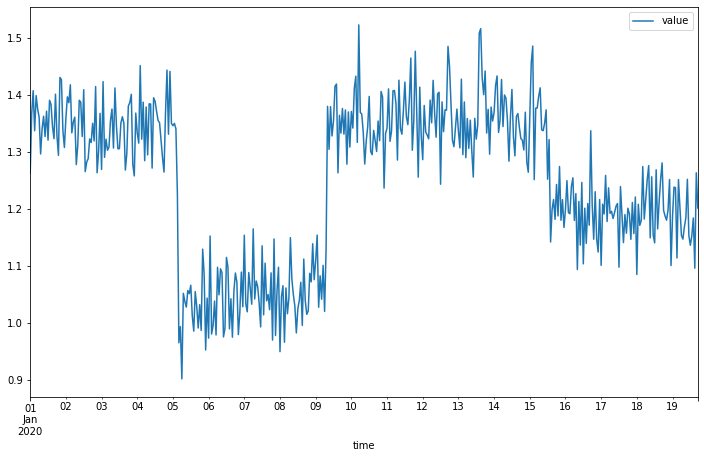

In [ ]:
from kats.utils.simulator import Simulator

sim = Simulator(n=450, start='2020-01-01', freq='H')
ts_bocpd = sim.level_shift_sim(noise=0.05, seasonal_period=1)

# plot the simulated data
ts_bocpd.plot(cols=['value'])

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



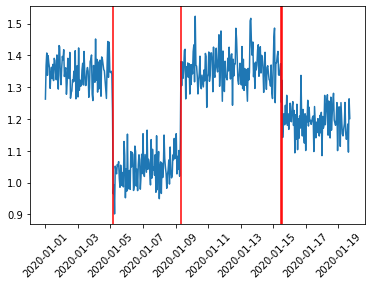

In [ ]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters, BOCPDChangePoint
import matplotlib.pyplot as plt
# Initialize the detector
detector = BayesOCPD(ts_bocpd)


changepoints, rt_pos = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL # this is the default choice
)

# Plot the data
detector.plot(changepoints)
plt.xticks(rotation=45)
plt.show()

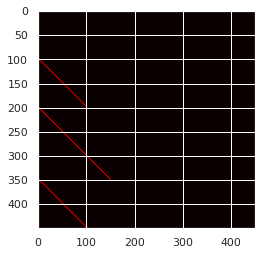

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.imshow(rt_pos[:,:,0], cmap ="hot")



In [ ]:


import logging
import math
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from enum import Enum
from typing import (
    Any,
    Dict,
    List,
    Optional,
    Sequence,
    Tuple,
    Type,
    Union,
    cast,
    Callable,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kats.consts import TimeSeriesChangePoint, TimeSeriesData, SearchMethodEnum
from kats.detectors.detector import Detector
from scipy.special import logsumexp 
from scipy.stats import invgamma, linregress, norm, nbinom  
from kats.detectors.bocpd import BOCPDModelParameters, _BayesOnlineChangePoint, SupportedModelType

class BOD(_BayesOnlineChangePoint):
      def posterior(self):
        return self.rt_posterior
class BayesOCPD(BOCPDetector):
  def detector(
        self,
        model: BOCPDModelType = BOCPDModelType.NORMAL_KNOWN_MODEL,
        model_parameters: Optional[BOCPDModelParameters] = None,
        lag: int = 10,
        choose_priors: bool = True,
        changepoint_prior: float = 0.01,
        threshold: float = 0.5,
        debug: bool = False,
        agg_cp: bool = True,
    ) -> Sequence[BOCPDChangePoint]:
        assert (
            model in self.available_models
        ), f"Requested model {model} not currently supported. Please choose one from: {self.available_models}"

        if model_parameters is None:
            model_parameters = self.parameter_type[model]()

        assert isinstance(
            model_parameters, self.parameter_type[model]
        ), f"Expected parameter type {self.parameter_type[model]}, but got {model_parameters}"

        if choose_priors:
            changepoint_prior, model_parameters = self._choose_priors(
                model, model_parameters
            )

        if getattr(model_parameters, "data", 0) is None:
            model_parameters.data = self.data

        logging.debug(f"Newest model parameters: {model_parameters}")

        if not self.data.is_univariate() and not self.models[model].is_multivariate():
            msg = "Model {model.name} support univariate time series, but get {type}.".format(
                model=model, type=type(self.data.value)
            )
            logging.error(msg)
            raise ValueError(msg)

        # parameters_dict = dataclasses.asdict(model_parameters)

        assert isinstance(model_parameters, self.parameter_type[model])
        underlying_model = self.models[model](
            data=self.data,
            # pyre-fixme[6]: In call `_BayesianLinReg.__init__`, for 2nd parameter `parameters` expected `TrendChangeParameters` but got `Union[NormalKnownParameters, PoissonModelParameters, TrendChangeParameters]`.
            # pyre-fixme[6]: In call `_NormalKnownPrec.__init__`, for 2nd parameter `parameters` expected `NormalKnownParameters` but got `Union[NormalKnownParameters, PoissonModelParameters, TrendChangeParameters]`.
            # pyre-fixme[6]: In call `_PoissonProcessModel.__init__`, for 2nd parameter `parameters` expected `PoissonModelParameters` but got `Union[NormalKnownParameters, PoissonModelParameters, TrendChangeParameters]`.
            parameters=model_parameters,
        )
        underlying_model.setup()

        logging.debug(f"Creating detector with lag {lag} and debug option {debug}.")
        bocpd = BOD(
            data=self.data, lag=lag, debug=debug, agg_cp=agg_cp
        )

        logging.debug(
            f"Running .detector() with model {underlying_model}, threshold {threshold}, changepoint prior {changepoint_prior}."
        )
        detector_results_all = bocpd.detector(
            model=underlying_model,
            threshold=threshold,
            changepoint_prior=changepoint_prior,
        )
        matrix = bocpd.posterior()
        self.detected_flag = True

        change_points = []
        for ts_name, detector_results in detector_results_all.items():
            change_indices = detector_results["change_points"]
            change_probs = detector_results["change_prob"]
            self.change_prob[ts_name] = change_probs
            self._run_length_prob[ts_name] = detector_results["run_length_prob"]

            logging.debug(
                f"Obtained {len(change_indices)} change points from underlying model in ts={ts_name}."
            )

            for cp_index in change_indices:
                cp_time = self.data.time.values[cp_index]
                cp = BOCPDChangePoint(
                    start_time=cp_time,
                    end_time=cp_time,
                    confidence=change_probs[cp_index],
                    model=model,
                    ts_name=ts_name,
                )
                change_points.append(cp)

            logging.debug(f"Found {len(change_points)} change points in ts={ts_name}.")

        return change_points, matrix

